<a href="https://colab.research.google.com/github/hashil7/-Image-Caption-Generation/blob/main/Final_image_captioning_lstm_cnn_4_5_2024_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Caption Generator with CNN & LSTM



## What is Image Caption Generator?

Image caption generator is a task that involves computer vision and natural language processing concepts to recognize the context of an image and describe them in a natural language like English.

### Image Caption Generator with CNN –

The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.

In this Python project, we will be implementing the caption generator using **CNN (Convolutional Neural Networks)***and LSTM **(Long short term memory)**.

# The Dataset of Python based Project

For the image caption generator, we will be using the Flickr_8K dataset. There are also other big datasets like Flickr_30K and MSCOCO dataset but it can take weeks just to train the network so we will be using a small Flickr8k dataset. The advantage of a huge dataset is that we can build better models.

we get dataset from **Kaggle** you can download it from here also : <a href="https://www.kaggle.com/datasets/adityajn105/flickr8k">Kaggle-Flicker8k</a> (Size: 1GB).


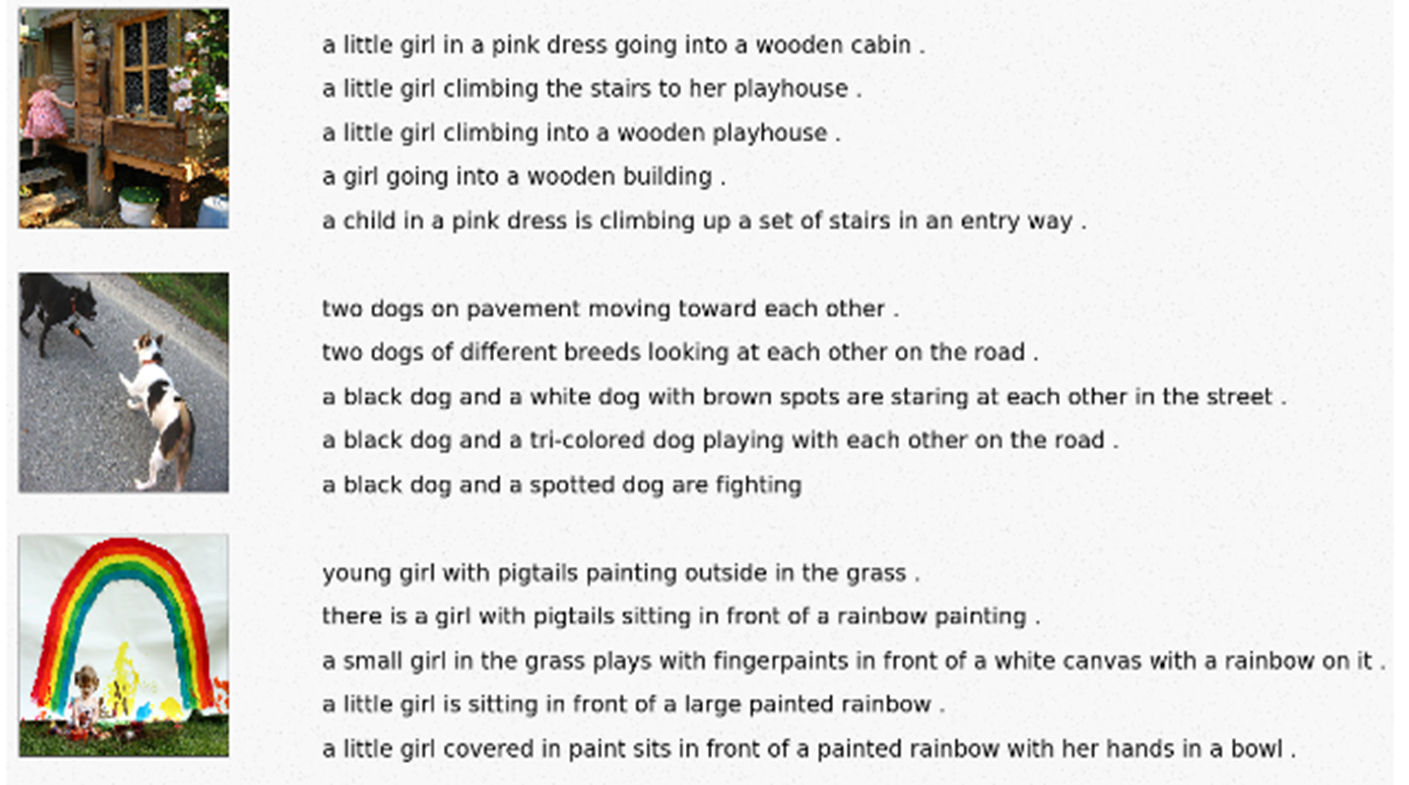

#Genral Overview

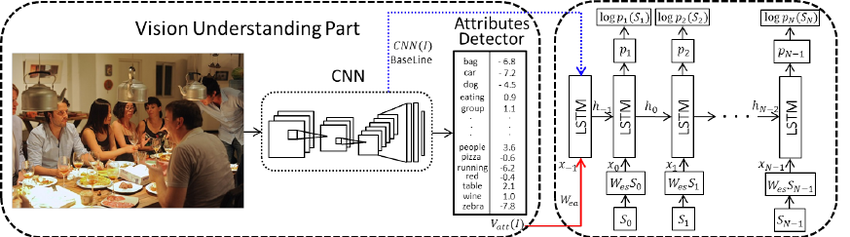

#### CODE

# Import Modules

In [ ]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

#### Now we must set the directories to use the data

In [ ]:
# Set base and working directories
BASE_DIR = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/flickr8k'  # Path to the directory containing the dataset
WORKING_DIR = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation'  # Working directory in Google Colab
WORKING_DIR = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/flickr8k'  # Path to the directory containing the dataset

#Visualizing Flickr_8k Dataset

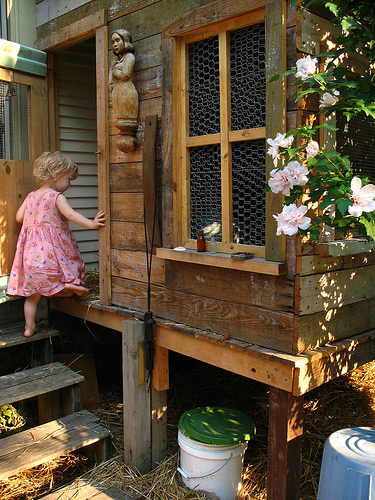

Captions:
A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


In [ ]:
import os
from PIL import Image
from IPython.display import display

# Paths to images and caption files
images_dir = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/flickr8k/Images'
captions_file = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/flickr8k/captions.txt'

# Load captions into a dictionary where keys are image filenames and values are lists of captions
captions = {}
with open(captions_file, 'r') as file:
    for line in file:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            image_filename, caption = parts[0], parts[1]
            if image_filename not in captions:
                captions[image_filename] = []
            captions[image_filename].append(caption)

# Choose an image to visualize (you can change this to visualize different images)
image_filename = '1000268201_693b08cb0e.jpg'
image_path = os.path.join(images_dir, image_filename)

# Load the image
image = Image.open(image_path)

# Display the image
display(image)

# Display its captions
print("Captions:")
for caption in captions[image_filename]:
    print(caption)


# Extract Image Features

We have to load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep.  A pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [ ]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

+ Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

# extract the image features
Now we extract the image features and load the data for preprocess

Number of featurs of each image = 4096

In [ ]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model

num_images = 4000


# # Load pre-trained VGG16 model
# model = VGG16()
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Extract features from the first 55 images in alphabetical order
features = {}
directory = os.path.join(BASE_DIR, 'Images')
image_names = sorted(os.listdir(directory))[:num_images]  # Get the first 55 images in alphabetical order

for img_name in tqdm(image_names):
    # load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for VGG
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature


100%|██████████| 4000/4000 [08:34<00:00,  7.78it/s]


In [ ]:
import os
import pickle
from google.colab import drive



# Define the file path where you want to save the features
file_path = '/content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/4000_image_flicker_4_5_2024_features.pickle'

# Save features to file
with open(file_path, 'wb') as f:
    pickle.dump(features, f)

print("Features saved successfully to:", file_path)


Features saved successfully to: /content/drive/MyDrive/NITC_Projects/Deep_Learning_Projects/Image_caption_generation/4000_image_flicker_4_5_2024_features.pickle


Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all your stored feature data to your project for quicker runtime

## Load the Captions Data

Let us store the captions data from the text file

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Now we split and append the captions data with the image

In [ ]:
# Create mapping of image to captions for the first 55 images in alphabetical order
mapping = {}
# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Check if the image ID is within the first 55 images
    if image_id in features:
        # Convert caption list to string
        caption = " ".join(caption)
        # Create list if needed
        if image_id not in mapping:
            mapping[image_id] = []
        # Store the caption
        mapping[image_id].append(caption)


100%|██████████| 40456/40456 [00:00<00:00, 670417.82it/s]


+ Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text

+ Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image

#### Now let us see the no. of images loaded

In [ ]:
len(mapping)

4000

# Preprocess Text Data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

Defined to clean and convert the text for quicker process and better results

Let us visualize the text **before** and **after** cleaning

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Next we will store the preprocessed captions into a list

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

20000

No. of unique captions stored

# 10 Captions
Let us see the first ten captions

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Processing of Text Data
Now we start processing the text data

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

6154

No. of unique words

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

+ Finding the maximum length of the captions, used for reference for the padding sequence.

# Train Test Split

#### After preprocessing the data now we will train, test and split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**Now we will define a batch and include the padding sequence**

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

X1 = features

X2 = in_seq = set of broken words( 1st word, 1st two words, ..1st word...35th word)

Y= out_seq( next word of input sequence)

#Word Embeddings

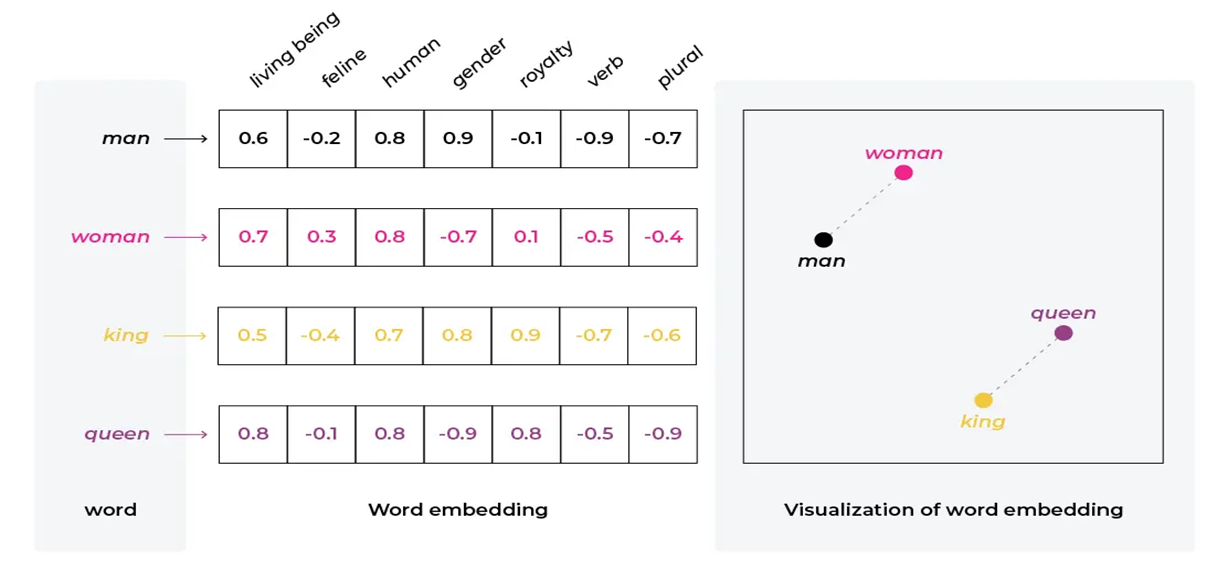


We have word embeddings( 1 d vector of size 256 )produced from vocab of size 4096( words)



Model Creation
cnn produces 4096 features for each image



# Model Creation

cnn produces 4096 features for each image

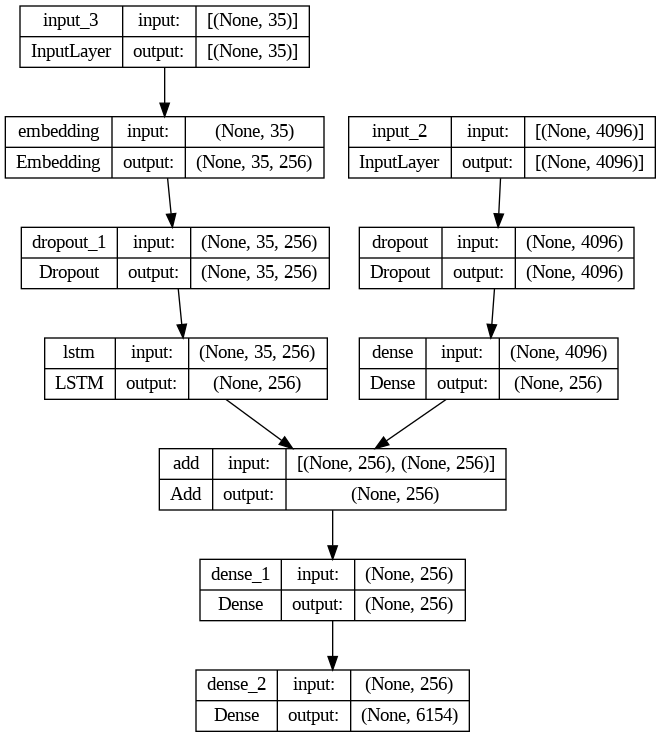

In [ ]:
# encoder model
# image feature layers
#cnn produces 4096 features for each image
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

The output is the probability of words in vocabulary

The output size is greater that vocb size due to padding

se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)

each word in vocab is of dimension 256( word embeddigs)

For prediction  , 1st on word and all image features will be input then it will will produce next word as output then it wil use these two words and image features as input and find the next word and so on to reach till max length we make a model so that its capable of this doing.

+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Train Model
Now let us train the model

Word = 256 1-d embedding(0r vector)

set of word or caption = (35,256)

A set of words( initially one, others 34 are zeros) and the features get in as input then decoder gives a vector which contains probability of words in vocabilary from which we get the highest prob the correct word.
next the previos wet of words and last ouput act and image features act as input and repeaats..

In [ ]:
epochs = 32
batch_size = 32
steps = len(train) // batch_size

# Lists to store training loss values
train_loss = []

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch and get history
    history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # append training loss to the list
    train_loss.append(history.history['loss'][0])

112/112 [==============================] - 29s 262ms/step - loss: 1.7316


+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss decreases gradually over the iterations

+ Increase the no. of epochs for better results

+ Assign the no. of epochs and batch size accordingly for quicker results




In [ ]:
# save the model
model.save(WORKING_DIR+'/4000_image_flicker_4_5_2024.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Load the saved model
model = load_model(WORKING_DIR+'/4000_image_flicker_4_5_2024.h5')

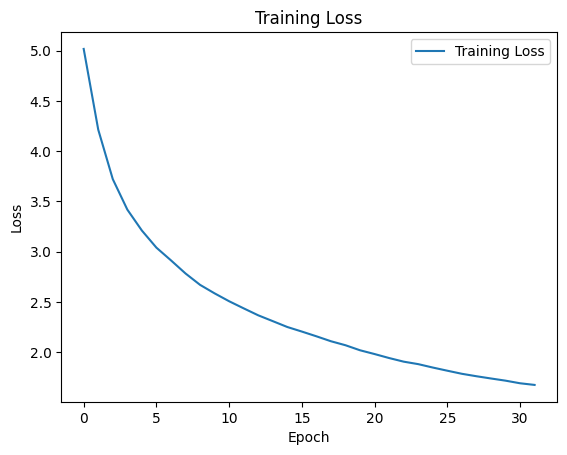

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_loss, label='Training Loss')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Generate Captions for the Image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

+ Convert the predicted index from the model into a word

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

+ Captiongenerator appending all the words for an image

+ The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation


## Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

+ Image caption generator defined

+ First prints the actual captions of the image then prints a predicted caption of the image

#Good Captions

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq black and white dog is staring at each other endseq


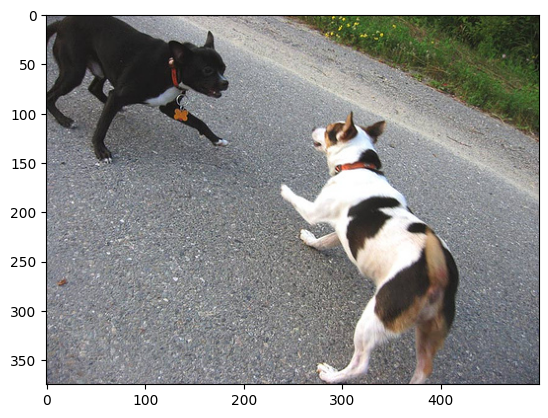

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is standing in front of rainbow painted rainbow endseq


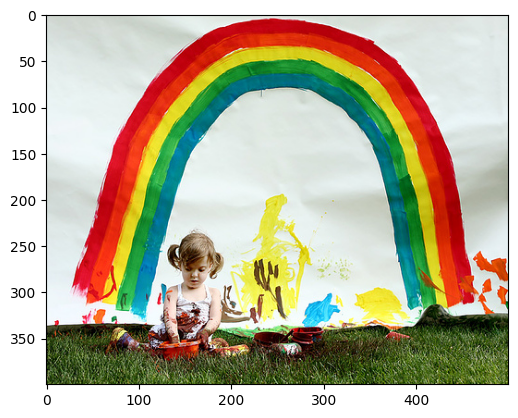

In [ ]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq four women in skis are displaying pictures endseq


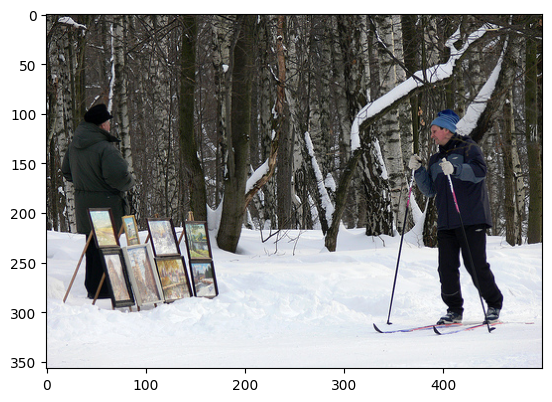

In [ ]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq closeup of an older man with glasses speaking endseq
startseq man wearing blue shirt and glasses endseq
startseq man with black-rimmed glasses and mustache is talking endseq
startseq man with glasses and mustache is in the middle of sentence endseq
startseq an older man with glasses is looking off camera endseq
--------------------Predicted--------------------
startseq man wearing black shirt is wearing black jacket endseq


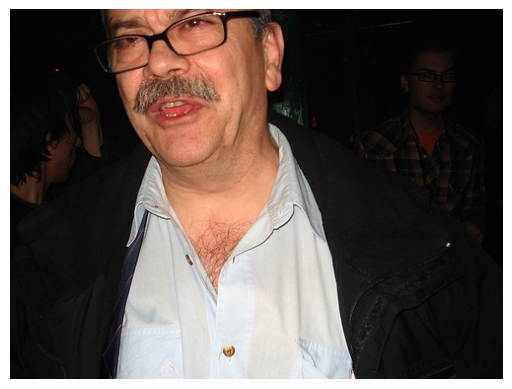

In [ ]:
import os
import random  # Import random module

def generate_random_caption(model, features, tokenizer, max_length, mapping, directory):
    # Select a random image from the test set
    random_image_name = random.choice(test)
    image_id = random_image_name.split('.')[0]
    img_path = os.path.join(directory, random_image_name)
    img_path = img_path + '.jpg'  # Append .jpg to the image path
    # Check if the image file exists
    if not os.path.exists(img_path):
        print(f"Image file '{random_image_name}' not found in '{directory}'")
        return



    # Load the image
    image = Image.open(img_path)
    # Get the actual captions
    actual_captions = mapping[image_id]
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    # Print actual captions
    print('---------------------Actual---------------------')
    for caption in actual_captions:
        print(caption)
    # Print predicted caption
    print('--------------------Predicted--------------------')
    print(y_pred)
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)


---------------------Actual---------------------
startseq bicycler does trick in the air and his shadow is captured on the ceiling endseq
startseq boy doing trick in the air on his bicycle endseq
startseq man in brown shirt and jeans is doing trick on his bicycle endseq
startseq man performing bicycle trick inside in midair endseq
startseq the man is doing trick on bike in midair endseq
--------------------Predicted--------------------
startseq one person is jumping over the fence on the wall endseq


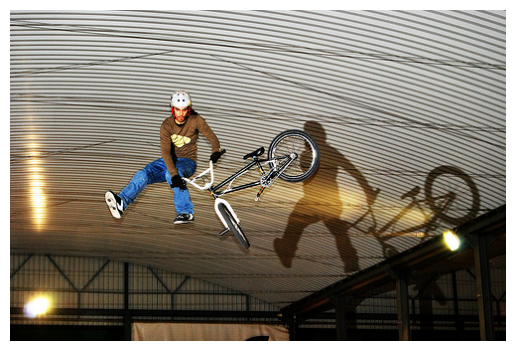

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq black and white dog is jumping fences in dog show endseq
startseq black and white dog jumping over steeple vault at competition endseq
startseq black and white dog performs jump with his owner looking on endseq
startseq black and white dog running through an obstacle course endseq
startseq dog leaping over hurdle endseq
--------------------Predicted--------------------
startseq black and white dog leaps over beam endseq


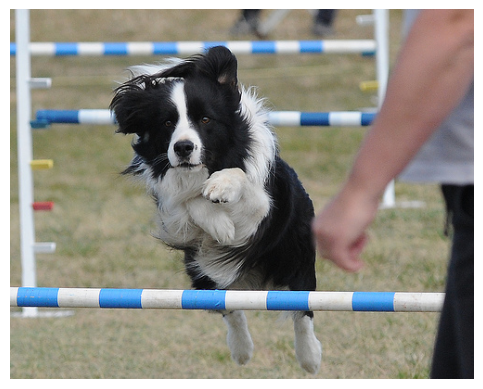

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq black dog looks into pool of water endseq
startseq black dog sniffing the ground near body of water endseq
startseq black dog with red collar sniffs the ground endseq
startseq the dog is looking at the water endseq
startseq this hound is searching the water for his prey endseq
--------------------Predicted--------------------
startseq black dog is running through the grass endseq


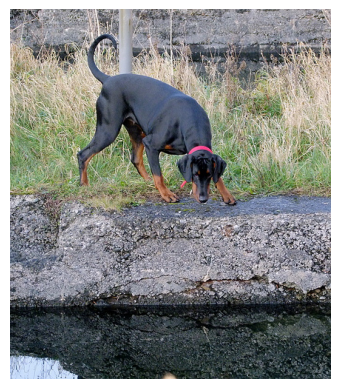

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq boy is jumping over large hole in the ground endseq
startseq person jumping into hole endseq
startseq wmoan is jumping off land and into ditch endseq
startseq young boy jumps in the air on pathway under construction in the hills endseq
startseq the little kids is jumping off ledge and into the dirt below it endseq
--------------------Predicted--------------------
startseq man is jumping off rock while jumping off of water endseq


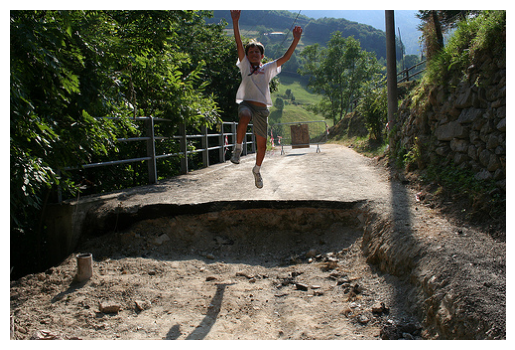

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq group of men play soccer on the field endseq
startseq man in red uniform leaps in the air as one in white uniform tries to kick ball endseq
startseq "during soccer game one man is in the air while another has one foot down ." endseq
startseq the soccer player in white is challenging the player in red for the ball in midair endseq
startseq "two soccer teams are playing one is in white the other in red ." endseq
--------------------Predicted--------------------
startseq football player in red uniform is tackling player in red uniform endseq


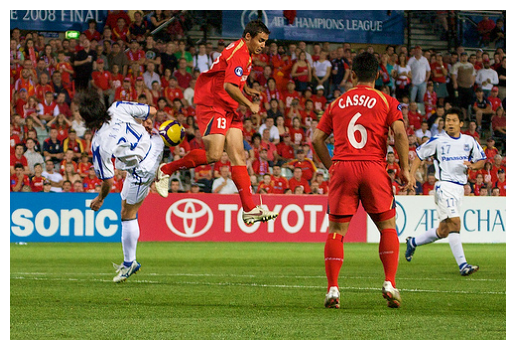

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq man in brown jacket and white shirt looks to his side endseq
startseq man in brown jacket looking off to the side endseq
startseq white man in jacket looks to his left endseq
startseq young man standing in crowded area endseq
startseq middle-aged man in casual clothes looking off camera endseq
--------------------Predicted--------------------
startseq man in black shirt is standing next to bush endseq


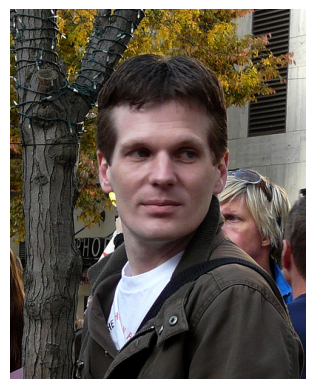

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq closeup of an older man with glasses speaking endseq
startseq man wearing blue shirt and glasses endseq
startseq man with black-rimmed glasses and mustache is talking endseq
startseq man with glasses and mustache is in the middle of sentence endseq
startseq an older man with glasses is looking off camera endseq
--------------------Predicted--------------------
startseq man wearing black shirt is wearing black jacket endseq


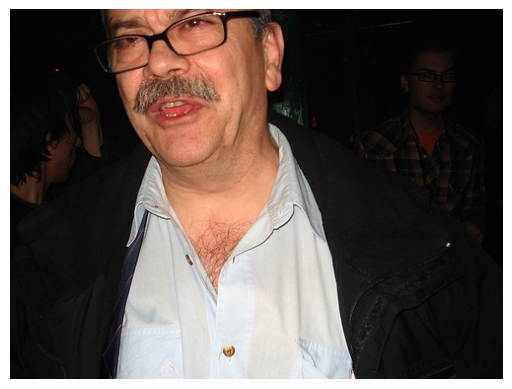

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq basketball player looks for someone to pass the ball to endseq
startseq man on the miami basketball team holds the ball getting ready to make move while being blocked endseq
startseq basketball player holding the ball endseq
startseq the basketball player holds the ball and looks across the court endseq
startseq the man is wearing an orange uniform and holding basketball endseq
--------------------Predicted--------------------
startseq a man in orange orange hat and orange hat is falling to the camera endseq


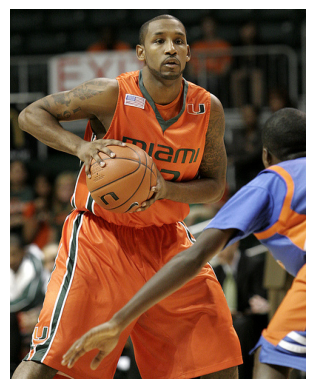

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

#Bad captions

---------------------Actual---------------------
startseq group of people dressed as zombies endseq
startseq large group of people with facepaint on gather outside endseq
startseq everybody is dressed as zombie at this party endseq
startseq many people have painted faces at night endseq
startseq people dressed up in zombie costumes are standing around endseq
--------------------Predicted--------------------
startseq three women in black dresses and black hats are examine hands endseq


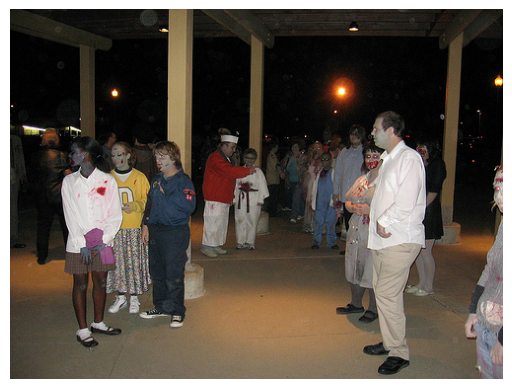

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq group of young men wrestle with each other wielding floppy toy sword endseq
startseq teenagers are playing with toy sword endseq
startseq the three people are playing around with fake knife endseq
startseq three men with mouths open and one is holding fake sword endseq
startseq two young men pretend to attack third man with colorful prop knife endseq
--------------------Predicted--------------------
startseq man is smiling at the other of red and red sticks endseq


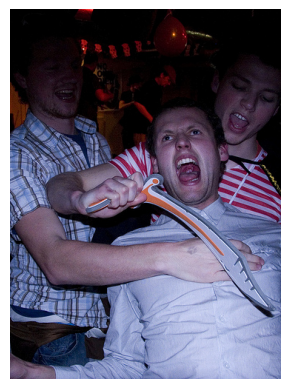

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

---------------------Actual---------------------
startseq closeup of man that is rock climbing endseq
startseq man cuts down tree with an ax endseq
startseq man in plaid shirt uses tool by tree endseq
startseq man in plaid shirt hits tree with an axe endseq
startseq man is scratching rock with red hammer endseq
--------------------Predicted--------------------
startseq man in blue helmet is climbing up the cliff endseq


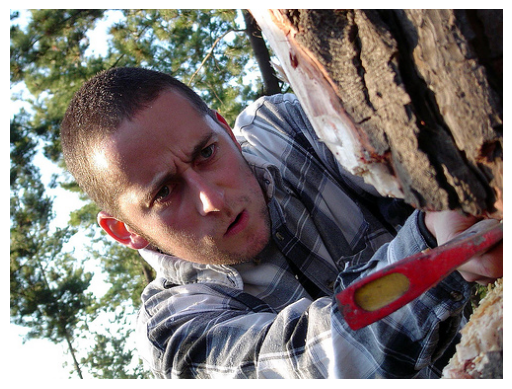

In [ ]:
# Usage example
generate_random_caption(model, features, tokenizer, max_length, mapping, directory)

#BLEU Score

N- gram precision

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 400/400 [05:20<00:00,  1.25it/s]


BLEU-1: 0.530135
BLEU-2: 0.295964


+ BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the captions data (actual_captions)

+ A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

# Final Thoughts

+ Training the model by increasing the no. of epochs can give better and more accurate results.

+ Processing large amount of data can take a lot of time and system resource.

+ The no. of layers of the model can be increased  to process large dataset like flickr32k.



